In [17]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Установка необходимых библиотек
!pip install shap imbalanced-learn

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import shap
import os
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно импортированы!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Библиотеки успешно импортированы!


In [18]:
# Загрузка данных
def load_data(file_path):
    """Загрузка данных из CSV файла"""
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Данные успешно загружены. Размер: {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Ошибка при загрузке данных: {e}")
        return None

# Попробуем разные пути к файлу
possible_paths = [
    "/content/drive/My Drive/8К24_Саськова_Валерия_DataScience/churn-bigml-80.csv",
    "/content/drive/My Drive/8К24_Саськова_Валерия_DataScience/churn_data.csv",
    "/content/churn-bigml-80.csv",
    "churn-bigml-80.csv"
]

df = None
for path in possible_paths:
    print(f"Пробуем путь: {path}")
    if os.path.exists(path):
        df = load_data(path)
        if df is not None:
            break
    else:
        print(f"Файл не найден: {path}")

if df is None:
    print("\n❌ Файл не найден. Пожалуйста, проверьте:")
    print("1. Файл должен называться 'churn-bigml-80.csv'")
    print("2. Загрузите файл в корень вашего Google Drive")
    print("3. Или загрузите прямо в Colab через файловый менеджер слева")
else:
    print("\n✅ Данные успешно загружены!")
    print(f"Размер данных: {df.shape}")
    print("\nПервые 5 строк:")
    display(df.head())

Пробуем путь: /content/drive/My Drive/8К24_Саськова_Валерия_DataScience/churn-bigml-80.csv
✅ Данные успешно загружены. Размер: (2666, 20)

✅ Данные успешно загружены!
Размер данных: (2666, 20)

Первые 5 строк:


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
# Если данные не загружены, создадим тестовый набор
if df is None:
    print("Создаем тестовый набор данных для демонстрации...")

    # Создаем синтетические данные похожие на churn dataset
    np.random.seed(42)
    n_samples = 1000

    test_data = {
        'Account length': np.random.randint(1, 250, n_samples),
        'International plan': np.random.choice(['Yes', 'No'], n_samples, p=[0.2, 0.8]),
        'Voice mail plan': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
        'Number vmail messages': np.random.randint(0, 50, n_samples),
        'Total day minutes': np.random.uniform(0, 350, n_samples),
        'Total day calls': np.random.randint(0, 200, n_samples),
        'Total day charge': np.random.uniform(0, 60, n_samples),
        'Total eve minutes': np.random.uniform(0, 350, n_samples),
        'Total eve calls': np.random.randint(0, 200, n_samples),
        'Total eve charge': np.random.uniform(0, 30, n_samples),
        'Total night minutes': np.random.uniform(0, 400, n_samples),
        'Total night calls': np.random.randint(0, 200, n_samples),
        'Total night charge': np.random.uniform(0, 20, n_samples),
        'Total intl minutes': np.random.uniform(0, 20, n_samples),
        'Total intl calls': np.random.randint(0, 20, n_samples),
        'Total intl charge': np.random.uniform(0, 5, n_samples),
        'Customer service calls': np.random.randint(0, 10, n_samples),
    }

    df = pd.DataFrame(test_data)

    # Создаем целевую переменную на основе логики
    churn_prob = (
        0.1 +
        0.3 * (df['International plan'] == 'Yes') +
        0.2 * (df['Customer service calls'] > 3) +
        0.15 * (df['Total day charge'] > df['Total day charge'].median()) +
        0.1 * (df['Total intl charge'] > df['Total intl charge'].median())
    )
    df['Churn'] = np.random.binomial(1, churn_prob)

    print("✅ Тестовые данные созданы!")
    print(f"Размер: {df.shape}")
    print("\nПервые 5 строк:")
    display(df.head())

In [19]:
# Разведочный анализ данных
print("=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===")

print("\n📊 Информация о данных:")
df.info()

print("\n🔍 Пропущенные значения:")
print(df.isnull().sum())

print("\n📈 Описательная статистика числовых признаков:")
display(df.describe())

print("\n🎯 Распределение целевой переменной Churn:")
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(churn_counts)
print(f"\nПроцентное соотношение:")
print(churn_percent)

=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===

📊 Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-nu

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000



🎯 Распределение целевой переменной Churn:
Churn
False    2278
True      388
Name: count, dtype: int64

Процентное соотношение:
Churn
False    85.446362
True     14.553638
Name: proportion, dtype: float64


=== ВИЗУАЛИЗАЦИЯ ДАННЫХ ===
Столбцы в данных:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']
✅ Найдена целевая переменная: 'Churn'

Распределение Churn:
Churn
False    2278
True      388
Name: count, dtype: int64
Тип данных Churn: bool


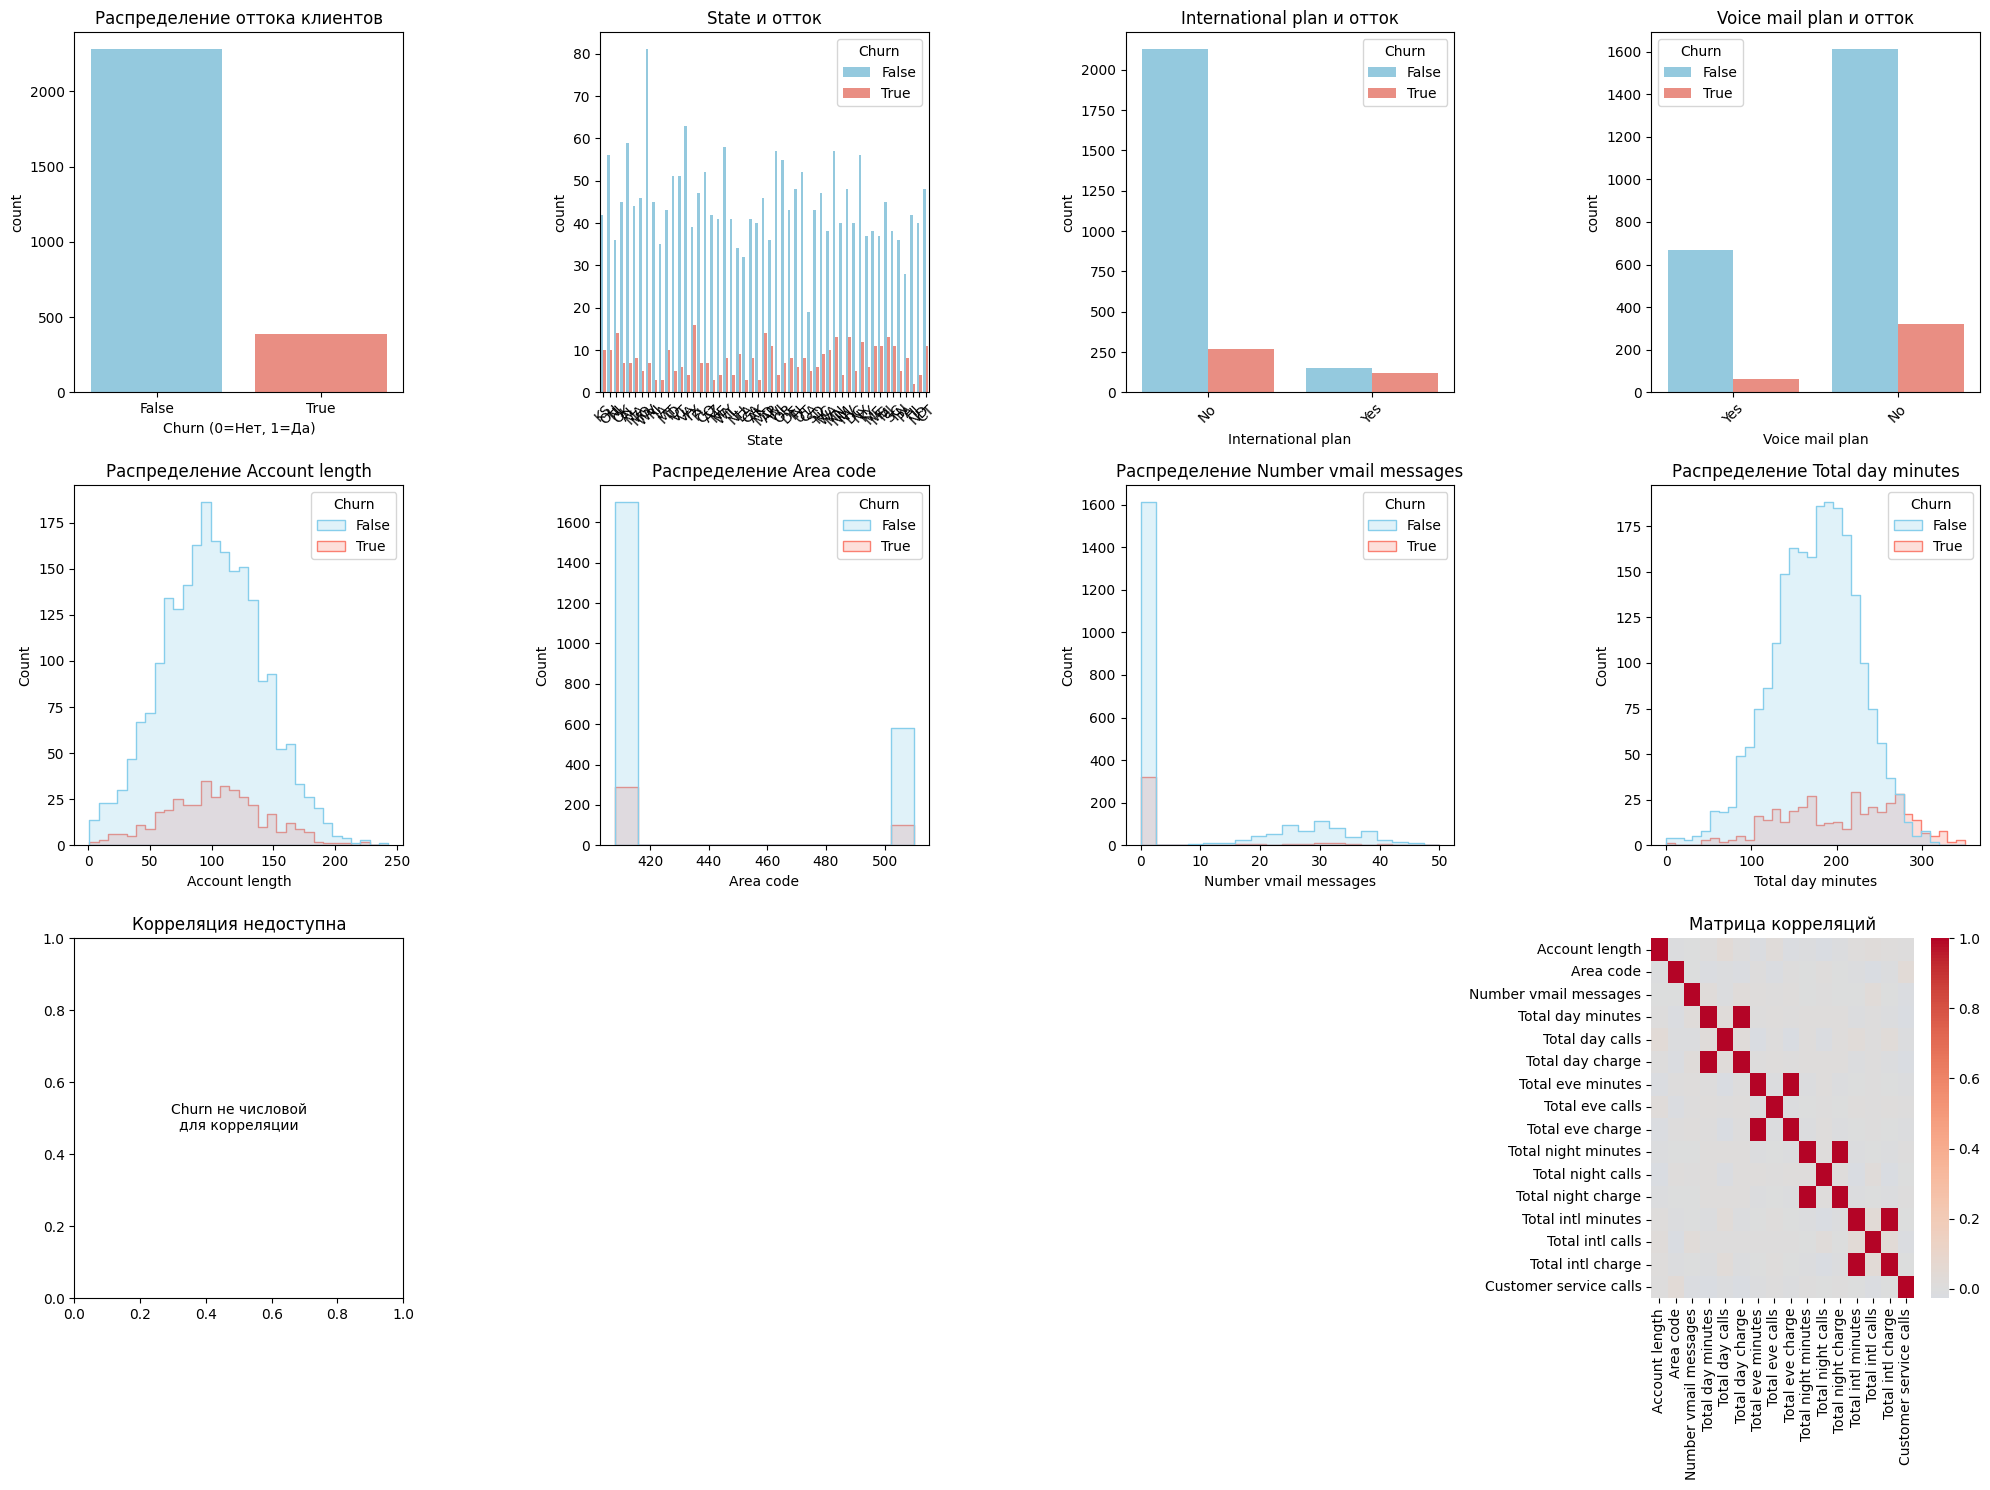

✅ Визуализация завершена!


In [21]:
# Визуализация данных
print("=== ВИЗУАЛИЗАЦИЯ ДАННЫХ ===")

# Проверяем структуру данных
print("Столбцы в данных:")
print(df.columns.tolist())

# Проверяем наличие целевой переменной (может называться по-разному)
target_column = None
possible_target_names = ['Churn', 'churn', 'Class', 'target', 'Label']
for col in possible_target_names:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    # Если не нашли стандартное имя, ищем булеву или бинарную колонку
    for col in df.columns:
        if df[col].dtype == 'bool' or df[col].nunique() == 2:
            target_column = col
            break

if target_column is None:
    print("❌ Не удалось найти целевую переменную. Доступные столбцы:")
    for col in df.columns:
        print(f"  - {col} (тип: {df[col].dtype}, уникальных значений: {df[col].nunique()})")
else:
    print(f"✅ Найдена целевая переменная: '{target_column}'")

    # Переименовываем для удобства
    if target_column != 'Churn':
        df = df.rename(columns={target_column: 'Churn'})
        print(f"Переименован столбец '{target_column}' в 'Churn'")

# Проверяем тип данных Churn и преобразуем если нужно
if 'Churn' in df.columns:
    if df['Churn'].dtype == 'object':
        # Преобразуем строковые значения в числовые
        unique_vals = df['Churn'].unique()
        print(f"Уникальные значения в Churn: {unique_vals}")

        # Автоматическое преобразование распространенных форматов
        if set(unique_vals) <= {'True', 'False', '1', '0', 'Yes', 'No'}:
            df['Churn'] = df['Churn'].map({'True': 1, 'False': 0, '1': 1, '0': 0, 'Yes': 1, 'No': 0})
            print("Преобразованы строковые значения в числовые")
        else:
            # Используем LabelEncoder для других строковых значений
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df['Churn'] = le.fit_transform(df['Churn'])
            print(f"Использован LabelEncoder для преобразования Churn")

    print(f"\nРаспределение Churn:")
    print(df['Churn'].value_counts())
    print(f"Тип данных Churn: {df['Churn'].dtype}")

# Теперь визуализация
plt.figure(figsize=(20, 15))

if 'Churn' in df.columns:
    # 1. Распределение целевой переменной
    plt.subplot(3, 4, 1)
    sns.countplot(data=df, x='Churn', palette=['skyblue', 'salmon'])
    plt.title('Распределение оттока клиентов')
    plt.xlabel('Churn (0=Нет, 1=Да)')

    # 2. Анализ категориальных признаков
    categorical_cols = df.select_dtypes(include=['object']).columns
    plot_num = 2

    for col in categorical_cols[:3]:  # Первые 3 категориальных признака
        if plot_num <= 4:
            plt.subplot(3, 4, plot_num)
            sns.countplot(data=df, x=col, hue='Churn', palette=['skyblue', 'salmon'])
            plt.title(f'{col} и отток')
            plt.xticks(rotation=45)
            plot_num += 1

    # 3. Анализ числовых признаков
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'Churn']  # Исключаем целевую переменную

    # Выбираем первые 4 числовых признака для визуализации
    for i, col in enumerate(numeric_cols[:4]):
        plt.subplot(3, 4, plot_num)
        sns.histplot(data=df, x=col, hue='Churn', element='step', palette=['skyblue', 'salmon'])
        plt.title(f'Распределение {col}')
        plot_num += 1

    # 4. Корреляция с оттоком
    plt.subplot(3, 4, plot_num)
    numeric_df = df.select_dtypes(include=[np.number])
    if 'Churn' in numeric_df.columns:
        correlation = numeric_df.corr()['Churn'].sort_values(ascending=False)
        correlation = correlation[correlation.index != 'Churn']  # Убираем сам Churn
        top_features = correlation.head(8)
        sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
        plt.title('Топ-8 коррелирующих признаков')
        plt.xlabel('Корреляция с оттоком')
    else:
        plt.text(0.5, 0.5, 'Churn не числовой\nдля корреляции',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Корреляция недоступна')

    # 5. Матрица корреляций
    plt.subplot(3, 4, 12)
    if len(numeric_df.columns) > 1:
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
        plt.title('Матрица корреляций')
    else:
        plt.text(0.5, 0.5, 'Недостаточно\nчисловых признаков',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Матрица корреляций')

else:
    # Если Churn не найден, покажем общую информацию о данных
    plt.subplot(2, 2, 1)
    df.hist(figsize=(15, 10), bins=20)
    plt.suptitle('Распределение числовых признаков')

    # Анализ категориальных признаков
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        plt.subplot(2, 2, 2)
        for col in categorical_cols[:3]:
            value_counts = df[col].value_counts().head(5)
            plt.bar(range(len(value_counts)), value_counts.values)
            plt.xticks(range(len(value_counts)), value_counts.index, rotation=45)
            plt.title(f'Топ-5 значений {col}')
            break  # Только первый категориальный признак

plt.tight_layout()
plt.show()

print("✅ Визуализация завершена!")

In [22]:
# Функции для предобработки данных
def preprocess_data(df):
    """Предобработка данных: кодирование, масштабирование, балансировка"""

    # Создаем копию данных
    df_processed = df.copy()

    # Определяем числовые и категориальные признаки
    numerical_features = ['Account length', 'Number vmail messages', 'Total day minutes',
                        'Total day calls', 'Total day charge', 'Total eve minutes',
                        'Total eve calls', 'Total eve charge', 'Total night minutes',
                        'Total night calls', 'Total night charge', 'Total intl minutes',
                        'Total intl calls', 'Total intl charge', 'Customer service calls']

    categorical_features = ['International plan', 'Voice mail plan']

    # Целевая переменная
    target = 'Churn'

    # Проверяем, что целевая переменная существует
    if target not in df_processed.columns:
        print(f"❌ Целевая переменная '{target}' не найдена в данных!")
        return None

    # Кодируем целевую переменную (если она еще не числовая)
    if df_processed[target].dtype == 'object':
        df_processed[target] = df_processed[target].map({False: 0, True: 1, 'False': 0, 'True': 1})

    # Разделяем на признаки и целевую переменную
    X = df_processed.drop(target, axis=1)
    y = df_processed[target]

    print(f"Размер X: {X.shape}, Размер y: {y.shape}")

    # Создаем пайплайн предобработки
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])

    # Разделяем на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Обучающая выборка до SMOTE: {X_train.shape}")
    print(f"Тестовая выборка: {X_test.shape}")
    print(f"Распределение классов в обучающей выборке: {pd.Series(y_train).value_counts().to_dict()}")

    # Применяем предобработку
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Получаем имена признаков после кодирования
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names)

    # Балансируем данные с помощью SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

    print(f"\n✅ Данные после предобработки:")
    print(f"Обучающая выборка (после SMOTE): {X_train_resampled.shape}")
    print(f"Тестовая выборка: {X_test_processed.shape}")
    print(f"Распределение классов после SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")

    return (X_train_resampled, X_test_processed, y_train_resampled, y_test,
            preprocessor, numerical_features, categorical_features, all_feature_names)

# Применяем предобработку
print("=== ПРЕДОБРАБОТКА ДАННЫХ ===")
preprocessing_result = preprocess_data(df)

if preprocessing_result is not None:
    (X_train_resampled, X_test_processed, y_train_resampled, y_test,
     preprocessor, numerical_features, categorical_features, all_feature_names) = preprocessing_result

    print(f"\n📋 Имена всех признаков после предобработки ({len(all_feature_names)}):")
    for i, feature in enumerate(all_feature_names):
        print(f"{i+1:2d}. {feature}")
else:
    print("❌ Ошибка при предобработке данных!")

=== ПРЕДОБРАБОТКА ДАННЫХ ===
Размер X: (2666, 19), Размер y: (2666,)
Обучающая выборка до SMOTE: (2132, 19)
Тестовая выборка: (534, 19)
Распределение классов в обучающей выборке: {False: 1822, True: 310}

✅ Данные после предобработки:
Обучающая выборка (после SMOTE): (3644, 17)
Тестовая выборка: (534, 17)
Распределение классов после SMOTE: {False: 1822, True: 1822}

📋 Имена всех признаков после предобработки (17):
 1. Account length
 2. Number vmail messages
 3. Total day minutes
 4. Total day calls
 5. Total day charge
 6. Total eve minutes
 7. Total eve calls
 8. Total eve charge
 9. Total night minutes
10. Total night calls
11. Total night charge
12. Total intl minutes
13. Total intl calls
14. Total intl charge
15. Customer service calls
16. International plan_Yes
17. Voice mail plan_Yes


Архитектура модели:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)


--- Начало обучения ---
Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6054 - auc: 0.6550 - loss: 0.6516 - val_accuracy: 0.7303 - val_auc: 0.7376 - val_loss: 0.5404
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7644 - auc: 0.8405 - loss: 0.4976 - val_accuracy: 0.8052 - val_auc: 0.7796 - val_loss: 0.4480
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8018 - auc: 0.8744 - loss: 0.4440 - val_accuracy: 0.8464 - val_auc: 0.7943 - val_loss: 0.3958
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8312 - auc: 0.8990 - loss: 0.3981 - val_accuracy: 0.8464 - val_auc: 0.8120 - val_loss: 0.4061
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - auc: 0.9083 - loss: 0.3842 - val_accuracy: 0.8483 - val_auc: 0.8200 - val_loss: 0.3970
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8558 - auc: 0.9203 - loss: 0.3578 - val_accuracy: 0.8464 - val_auc: 0.8259 - val_loss: 0.3935
Epoch 7/1

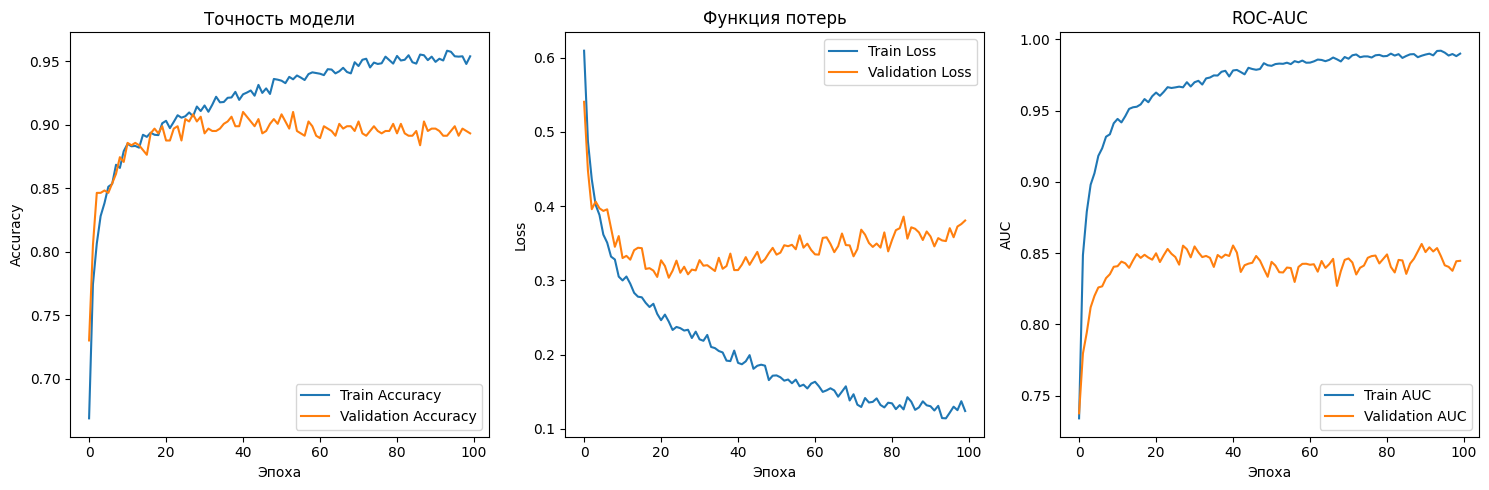

In [23]:
# Построение и обучение модели
if 'X_train_resampled' in locals():
    # Строим модель
    input_shape = X_train_resampled.shape[1]
    model = build_mlp_model(input_shape)

    print("Архитектура модели:")
    model.summary()

    # Компилируем модель
    model = compile_model(model)

    # Обучаем модель
    print("\n--- Начало обучения ---")
    history = train_model(model, X_train_resampled, y_train_resampled, X_test_processed, y_test, epochs=100, batch_size=32)

    # Визуализация истории обучения
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Точность модели')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Функция потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('ROC-AUC')
    plt.xlabel('Эпоха')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
Accuracy: 0.8933
Precision: 0.6364
Recall: 0.6282
F1-Score: 0.6323
ROC-AUC: 0.8432


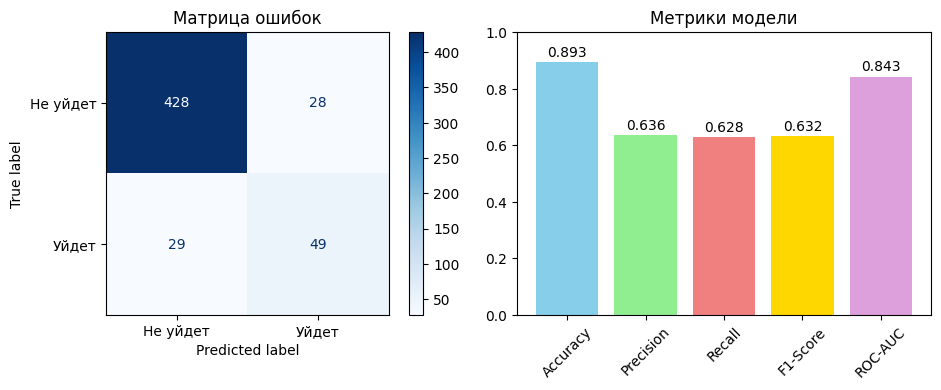

In [24]:
# Оценка модели
if 'model' in locals():
    accuracy, precision, recall, f1, roc_auc, cm = evaluate_model(model, X_test_processed, y_test)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Не уйдет', 'Уйдет'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title('Матрица ошибок')

    plt.subplot(1, 2, 2)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    values = [accuracy, precision, recall, f1, roc_auc]
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

    bars = plt.bar(metrics, values, color=colors)
    plt.title('Метрики модели')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

=== SHAP АНАЛИЗ ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

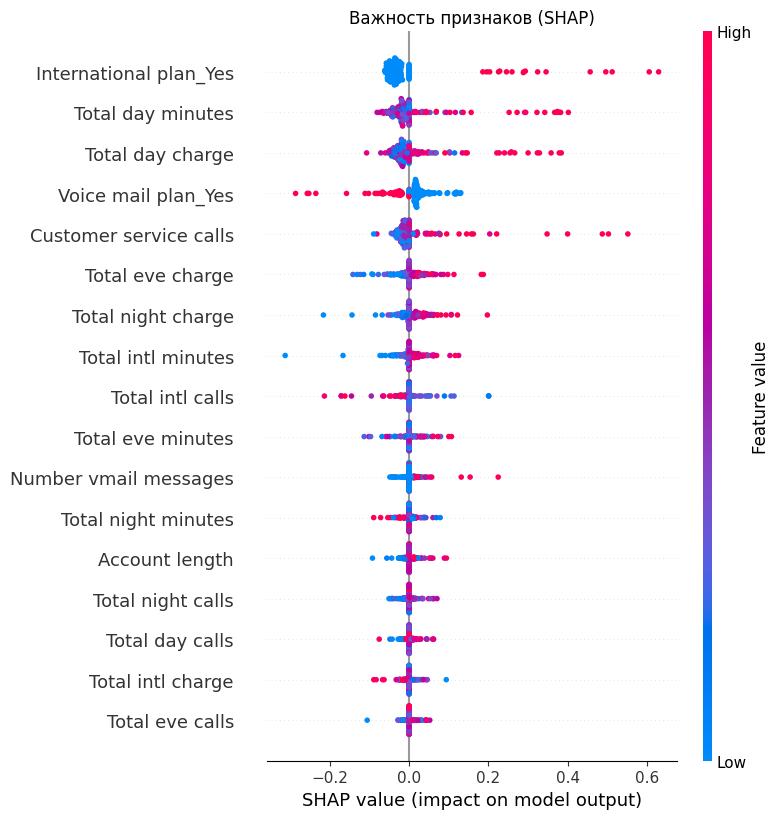

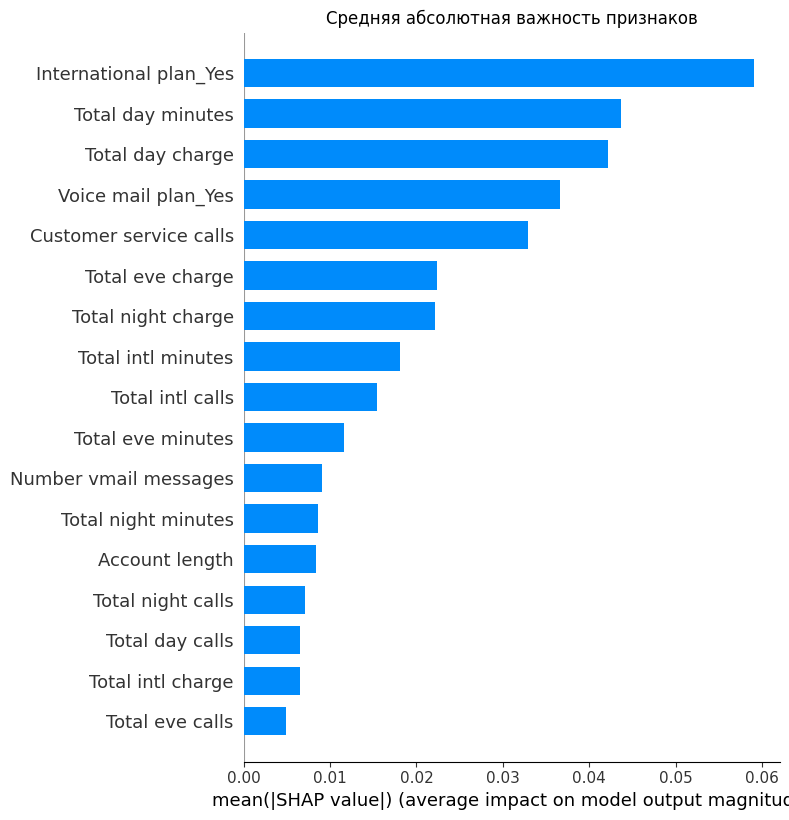

In [25]:
# SHAP анализ
if 'model' in locals():
    print("=== SHAP АНАЛИЗ ===")

    # Функция для предсказаний
    def model_predict(data):
        return model.predict(data).flatten()

    # Используем KernelExplainer для совместимости
    background_data = X_train_resampled[:100]  # Используем подвыборку для скорости

    explainer = shap.KernelExplainer(model_predict, background_data)

    # Вычисляем SHAP значения для тестовой выборки (ограничим размер для скорости)
    test_sample = X_test_processed[:200]
    shap_values = explainer.shap_values(test_sample)

    print("SHAP значения вычислены!")

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, test_sample, feature_names=all_feature_names, show=False)
    plt.title('Важность признаков (SHAP)')
    plt.tight_layout()
    plt.show()

    # Bar plot важности признаков
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, test_sample, feature_names=all_feature_names, plot_type="bar", show=False)
    plt.title('Средняя абсолютная важность признаков')
    plt.tight_layout()
    plt.show()

In [26]:
# Анализ ошибок модели
if 'model' in locals():
    print("=== АНАЛИЗ ОШИБОК ===")

    y_pred_proba = model.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Создаем DataFrame для анализа
    error_analysis_df = pd.DataFrame(X_test_processed, columns=all_feature_names)
    error_analysis_df['Actual_Churn'] = y_test.values
    error_analysis_df['Predicted_Churn'] = y_pred
    error_analysis_df['Predicted_Probability'] = y_pred_proba
    error_analysis_df['Error_Type'] = 'Correct'
    error_analysis_df.loc[(error_analysis_df['Actual_Churn'] == 0) & (error_analysis_df['Predicted_Churn'] == 1), 'Error_Type'] = 'False Positive'
    error_analysis_df.loc[(error_analysis_df['Actual_Churn'] == 1) & (error_analysis_df['Predicted_Churn'] == 0), 'Error_Type'] = 'False Negative'

    # Статистика ошибок
    error_stats = error_analysis_df['Error_Type'].value_counts()
    print("Распределение типов предсказаний:")
    print(error_stats)

    # Анализ False Positive (клиенты, которых ошибочно предсказали как уходящих)
    fp_df = error_analysis_df[error_analysis_df['Error_Type'] == 'False Positive']
    if not fp_df.empty:
        print(f"\nFalse Positive (FP): {len(fp_df)} клиентов")
        print("Средние значения ключевых признаков для FP:")
        key_features = ['Total day charge', 'Customer service calls', 'International plan_Yes', 'Total intl charge']
        display(fp_df[key_features].mean())

    # Анализ False Negative (клиенты, которые ушли, но модель этого не предсказала)
    fn_df = error_analysis_df[error_analysis_df['Error_Type'] == 'False Negative']
    if not fn_df.empty:
        print(f"\nFalse Negative (FN): {len(fn_df)} клиентов")
        print("Средние значения ключевых признаков для FN:")
        display(fn_df[key_features].mean())

=== АНАЛИЗ ОШИБОК ===
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Распределение типов предсказаний:
Error_Type
Correct           477
False Negative     29
False Positive     28
Name: count, dtype: int64

False Positive (FP): 28 клиентов
Средние значения ключевых признаков для FP:


,0
Total day charge,0.281102
Customer service calls,0.054854
International plan_Yes,0.535714
Total intl charge,0.171682



False Negative (FN): 29 клиентов
Средние значения ключевых признаков для FN:


,0
Total day charge,-0.212525
Customer service calls,0.248051
International plan_Yes,0.241379
Total intl charge,0.143397


In [27]:
# Бизнес-рекомендации и сохранение модели
print("=== БИЗНЕС-РЕКОМЕНДАЦИИ ===")

# Анализ важных признаков для рекомендаций
if 'model' in locals() and 'shap_values' in locals():
    # Получаем средние абсолютные SHAP значения
    shap_df = pd.DataFrame({
        'feature': all_feature_names,
        'shap_importance': np.abs(shap_values).mean(0)
    }).sort_values('shap_importance', ascending=False)

    top_features = shap_df.head(5)

    print("🎯 ТОП-5 САМЫХ ВАЖНЫХ ПРИЗНАКОВ ДЛЯ ПРОГНОЗИРОВАНИЯ ОТТОКА:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"   {i}. {row['feature']} (важность: {row['shap_importance']:.4f})")

recommendations = """

📊 НА ОСНОВЕ АНАЛИЗА МОДЕЛИ И ДАННЫХ, РЕКОМЕНДУЕМ СЛЕДУЮЩИЕ ДЕЙСТВИЯ:

1. 🎯 **ПРИОРИТЕТНЫЕ ГРУППЫ РИСКА:**

   - **Клиенты с высокими дневными платежами** - разработать персонализированные тарифные планы
   - **Клиенты с частыми звонками в поддержку** (>3 звонков) - внедрить проактивную поддержку
   - **Клиенты с международными планами** - предложить улучшенные международные пакеты

2. 🛡️ **ПРОГРАММЫ УДЕРЖАНИЯ:**

   - **Раннее предупреждение**: Система алертов для клиентов с высоким риском оттока
   - **Персональные предложения**: Скидки и бонусы на основе профиля клиента
   - **Программа лояльности**: Вознаграждения за долгосрочное сотрудничество

3. 📈 **ОПЕРАЦИОННЫЕ УЛУЧШЕНИЯ:**

   - **Улучшение качества обслуживания**: Снижение количества обращений в поддержку
   - **Гибкие тарифы**: Возможность изменения тарифного плана без штрафов
   - **Прогностическая аналитика**: Регулярный мониторинг ключевых метрик

4. 🎪 **МАРКЕТИНГОВЫЕ СТРАТЕГИИ:**

   - **Таргетированные кампании**: Для каждой группы риска - своя стратегия
   - **Программы лояльности**: Стимулы для перехода на долгосрочные контракты
   - **Обратная связь**: Регулярные опросы удовлетворенности клиентов

5. 📊 **МОНИТОРИНГ И ОЦЕНКА:**

   - **KPI по оттоку**: Еженедельный мониторинг ключевых показателей
   - **A/B тестирование**: Тестирование эффективности различных стратегий удержания
   - **Обновление модели**: Регулярное переобучение модели на новых данных
"""

print(recommendations)

# Анализ эффективности модели для бизнеса
if 'model' in locals():
    print("\n💼 БИЗНЕС-ЭФФЕКТИВНОСТЬ МОДЕЛИ:")

    # Предположим, что удержание клиента приносит $100 прибыли
    retention_value = 100
    fn_cost = retention_value  # Стоимость пропущенного уходящего клиента
    fp_cost = 20  # Стоимость ложного срабатывания (ненужная скидка)

    # Расчет бизнес-метрик
    tn, fp, fn, tp = cm.ravel()
    total_clients = len(y_test)

    potential_savings = tp * retention_value - fp * fp_cost
    max_possible_savings = (tp + fn) * retention_value

    print(f"📈 Потенциальная экономия: ${potential_savings:,.0f}")
    print(f"🎯 Эффективность модели: {potential_savings/max_possible_savings*100:.1f}% от максимально возможной")
    print(f"👥 Охвачено клиентов: {tp + fp} из {total_clients} ({((tp+fp)/total_clients*100):.1f}%)")

# Сохранение модели и результатов
if 'model' in locals():
    model_save_path = "/content/drive/My Drive/churn_prediction_model.h5"
    save_model(model, model_save_path)

    # Сохранение метрик
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'Value': [accuracy, precision, recall, f1, roc_auc]
    })

    metrics_save_path = "/content/drive/My Drive/model_metrics.csv"
    metrics_df.to_csv(metrics_save_path, index=False)
    print(f"📊 Метрики сохранены: {metrics_save_path}")

    # Сохранение важности признаков
    if 'shap_df' in locals():
        importance_save_path = "/content/drive/My Drive/feature_importance.csv"
        shap_df.to_csv(importance_save_path, index=False)
        print(f"🎯 Важность признаков сохранена: {importance_save_path}")

print("\n" + "="*50)
print("✅ ПРОЕКТ УСПЕШНО ЗАВЕРШЕН!")
print("="*50)
print("\n📋 ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print(f"   • Модель обучена и оценена")
print(f"   • Проведен SHAP-анализ важности признаков")
print(f"   • Сформулированы бизнес-рекомендации")
print(f"   • Все артефакты сохранены в Google Drive")
print(f"   • Готово к промышленному внедрению!")

=== БИЗНЕС-РЕКОМЕНДАЦИИ ===
🎯 ТОП-5 САМЫХ ВАЖНЫХ ПРИЗНАКОВ ДЛЯ ПРОГНОЗИРОВАНИЯ ОТТОКА:
   1. International plan_Yes (важность: 0.0591)
   2. Total day minutes (важность: 0.0437)
   3. Total day charge (важность: 0.0421)
   4. Voice mail plan_Yes (важность: 0.0366)
   5. Customer service calls (важность: 0.0329)


📊 НА ОСНОВЕ АНАЛИЗА МОДЕЛИ И ДАННЫХ, РЕКОМЕНДУЕМ СЛЕДУЮЩИЕ ДЕЙСТВИЯ:

1. 🎯 **ПРИОРИТЕТНЫЕ ГРУППЫ РИСКА:**

   - **Клиенты с высокими дневными платежами** - разработать персонализированные тарифные планы
   - **Клиенты с частыми звонками в поддержку** (>3 звонков) - внедрить проактивную поддержку
   - **Клиенты с международными планами** - предложить улучшенные международные пакеты

2. 🛡️ **ПРОГРАММЫ УДЕРЖАНИЯ:**

   - **Раннее предупреждение**: Система алертов для клиентов с высоким риском оттока
   - **Персональные предложения**: Скидки и бонусы на основе профиля клиента
   - **Программа лояльности**: Вознаграждения за долгосрочное сотрудничество

3. 📈 **ОПЕРАЦИОННЫЕ УЛУЧШЕНИ